# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from tlbo import TLBO

from sklearn.metrics import confusion_matrix
import seaborn as sns
from dataclasses import dataclass, field
from typing import Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import multiprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, make_scorer, log_loss
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.optimizers import RMSprop
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

2024-11-11 16:16:54.169364: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 16:16:54.170429: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 16:16:54.173878: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 16:16:54.183791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 16:16:54.199697: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# MLP

## Functions

In [16]:
def run_model(model, X_train, y_train, X_test, y_test, metric):
    if metric == 'train':
        loss_scorer = make_scorer(log_loss, response_method="predict_proba")
        scores = cross_val_score(model, X_train, y_train, cv=3, scoring=loss_scorer)
    
    elif metric == 'validation':
        scores = cross_val_score(model, X_train, y_train, cv=3)


    mean_loss = scores.mean()
    model.fit(X_train, y_train)
    mean_loss = round(mean_loss, 4)

    y_pred = model.predict(X_test)
    y_test = to_categorical(y_test, num_classes=6)
    test_accuracy = accuracy_score(y_test, y_pred)

    return scores, mean_loss, test_accuracy

def get_data(name: str, HOS = True):
    data = pd.read_csv(f'/home/rafael/Mestrado/Artigo TLBO/database/{name}.csv', delimiter=';')
    if HOS:
        data = data.drop(columns=['I313', 'I314', 'I315', 'I316', 'I317', 'I630', 'I631', 'I632', 'I633', 'I634'])
    
    elif HOS == False:
        data = data[['I313', 'I314', 'I315', 'I316', 'I317', 'I630', 'I631', 'I632', 'I633', 'I634', 'Output']]
    
    label_counts = data['Output'].value_counts().sort_index()
    data['Output'] = data['Output'] - 1
    data = data.dropna(axis=1)
    colunas_com_infinitos = data.columns[data.isin([np.inf, -np.inf]).any()]
    data = data.drop(columns=colunas_com_infinitos)

    y = data['Output']
    X = data.drop(columns=['Output'], inplace=False)
    return X, y

def create_model(X_train,y):
    model = Sequential([
        Dense(10, activation='tanh', input_shape=(X_train.shape[1],)),
        Dense(len(np.unique(y)), activation='softmax')
    ])
    optimizer = RMSprop(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def execute_model(name: str, HOS):
    X, y = get_data(name, HOS)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    model_mlp = KerasClassifier(build_fn=create_model(X_train,y), epochs=20, verbose=0)

    y_train = to_categorical(y_train, num_classes=6)
    (scores_mlp, mean_acc, test_acc) = run_model(model=model_mlp, 
                                                            X_train=X_train, 
                                                            y_train=y_train, 
                                                            X_test=X_test, 
                                                            y_test=y_test,
                                                            metric='validation')

    y_pred = model_mlp.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    return mean_acc, round(test_acc, 4)

## Homem 1

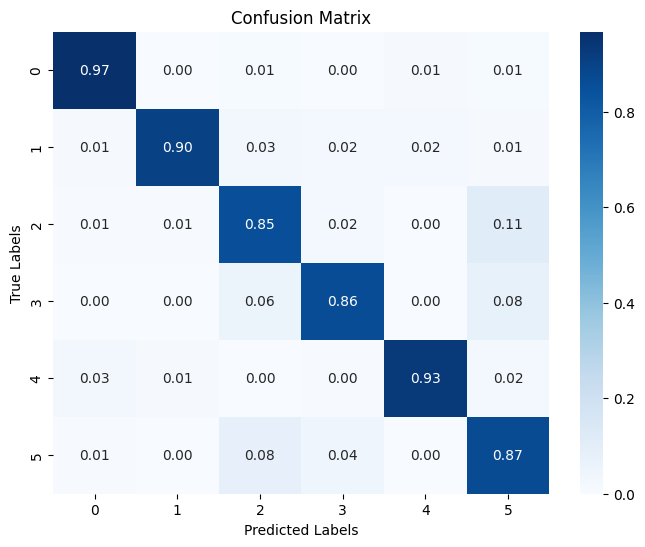

-------- HOS=True --------
Acc. Média Treino: 0.8882 | Acc. Média Teste: 0.8986


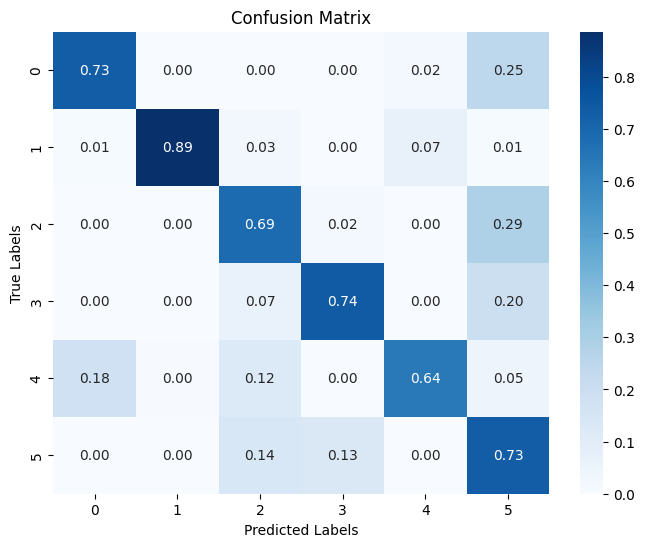

-------- HOS=False --------
Acc. Média Treino: 0.7283 | Acc. Média Teste: 0.7372


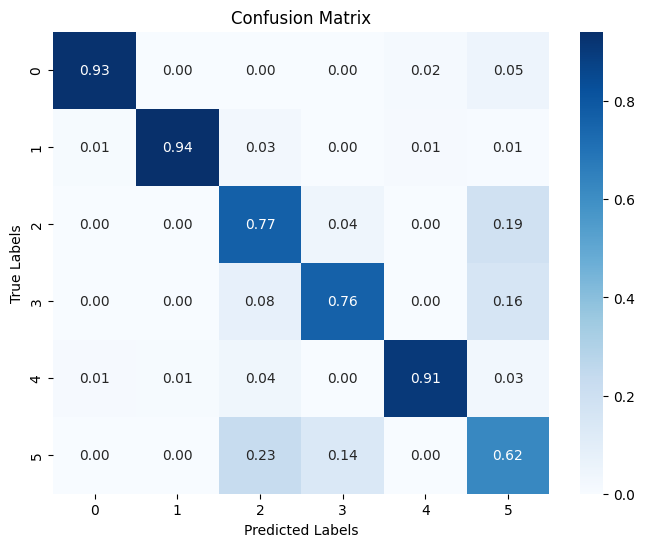

-------- HOS=None --------
Acc. Média Treino: 0.7338 | Acc. Média Teste: 0.8274


In [17]:
mean_acc, test_acc = execute_model(name='homem1', HOS=True)
print('-------- HOS=True --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='homem1', HOS=False)
print('-------- HOS=False --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='homem1', HOS=None)
print('-------- HOS=None --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

## Homem 2

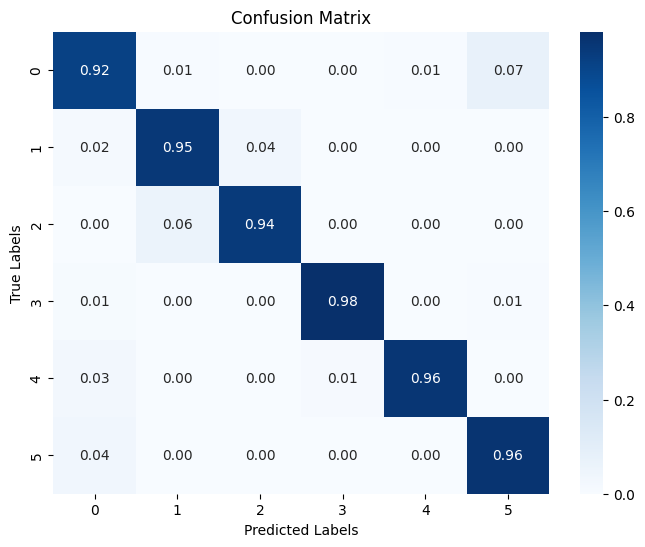

-------- HOS=True --------
Acc. Média Treino: 0.9528 | Acc. Média Teste: 0.9499


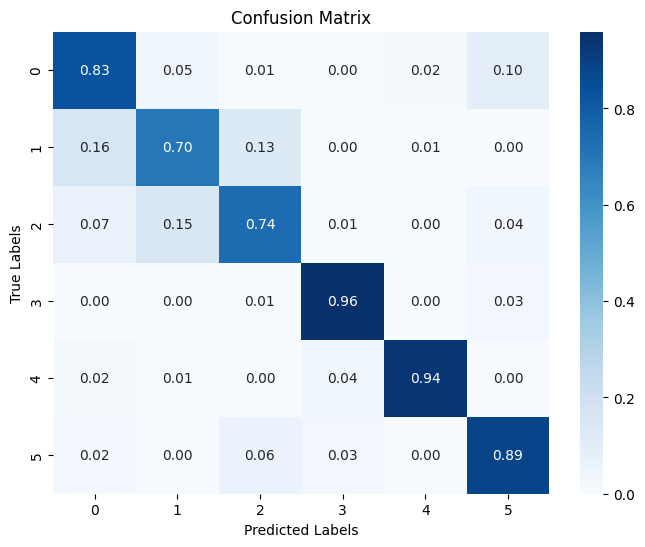

-------- HOS=False --------
Acc. Média Treino: 0.8184 | Acc. Média Teste: 0.8399


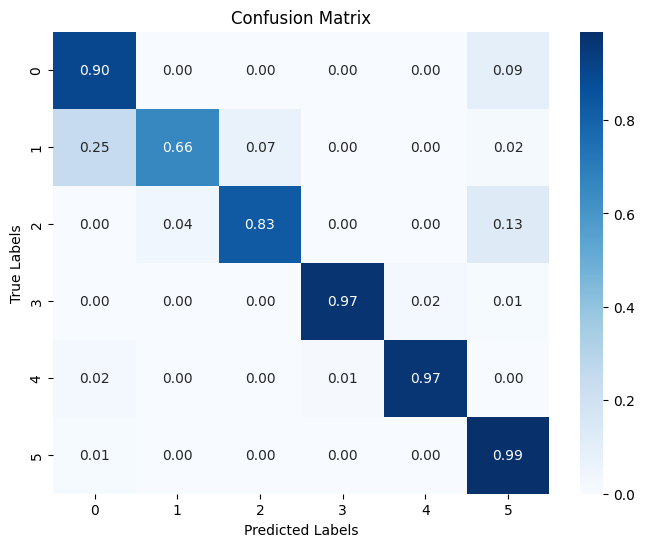

-------- HOS=None --------
Acc. Média Treino: 0.8388 | Acc. Média Teste: 0.8835


In [18]:
mean_acc, test_acc = execute_model(name='homem2', HOS=True)
print('-------- HOS=True --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='homem2', HOS=False)
print('-------- HOS=False --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='homem2', HOS=None)
print('-------- HOS=None --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

## Mulher 1

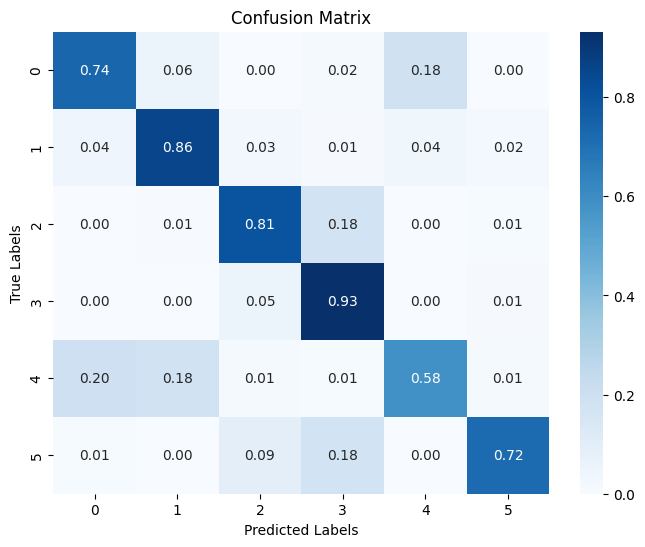

-------- HOS=True --------
Acc. Média Treino: 0.7695 | Acc. Média Teste: 0.7717


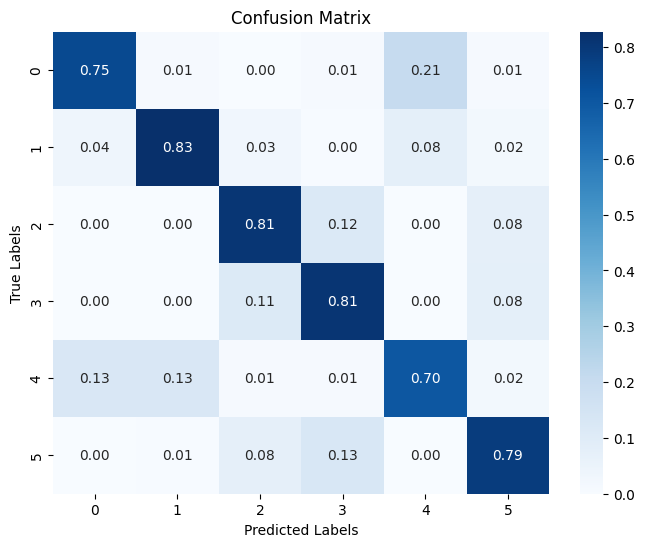

-------- HOS=False --------
Acc. Média Treino: 0.7108 | Acc. Média Teste: 0.7799


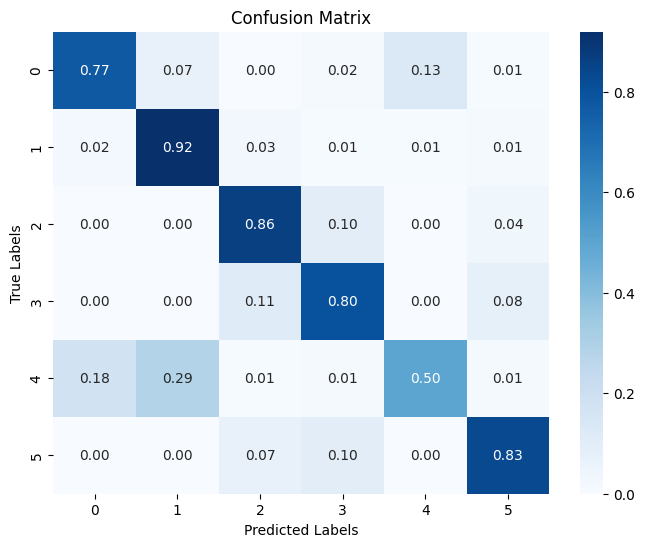

-------- HOS=None --------
Acc. Média Treino: 0.72 | Acc. Média Teste: 0.7803


In [19]:
mean_acc, test_acc = execute_model(name='mulher1', HOS=True)
print('-------- HOS=True --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher1', HOS=False)
print('-------- HOS=False --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher1', HOS=None)
print('-------- HOS=None --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

## Mulher2

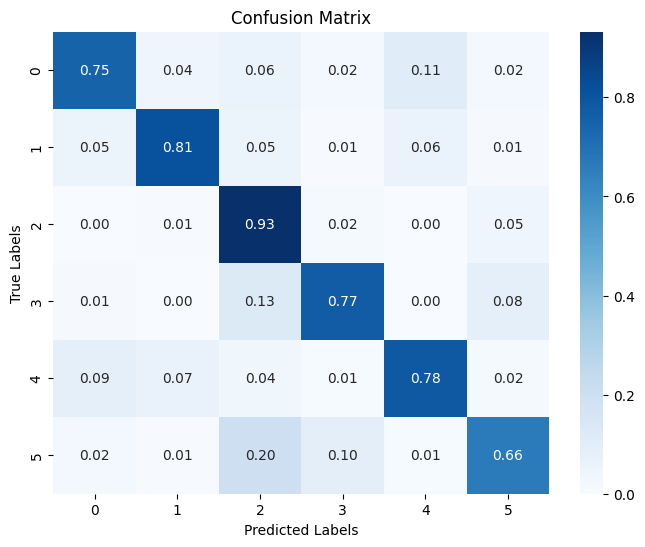

-------- HOS=True --------
Acc. Média Treino: 0.7438 | Acc. Média Teste: 0.7855


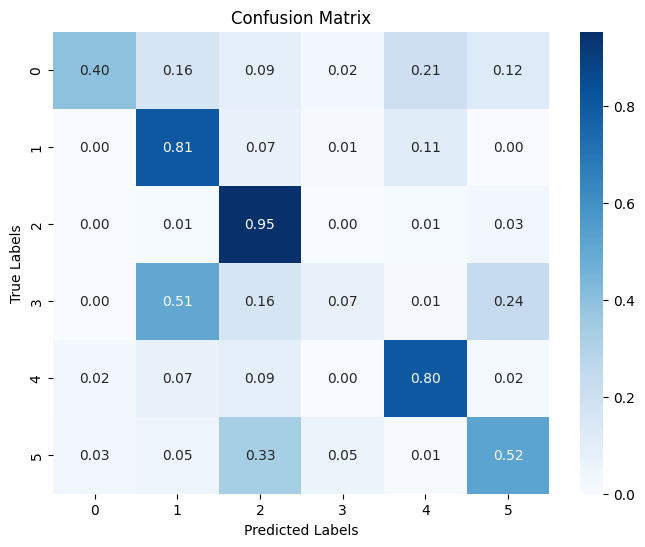

-------- HOS=False --------
Acc. Média Treino: 0.4812 | Acc. Média Teste: 0.5982


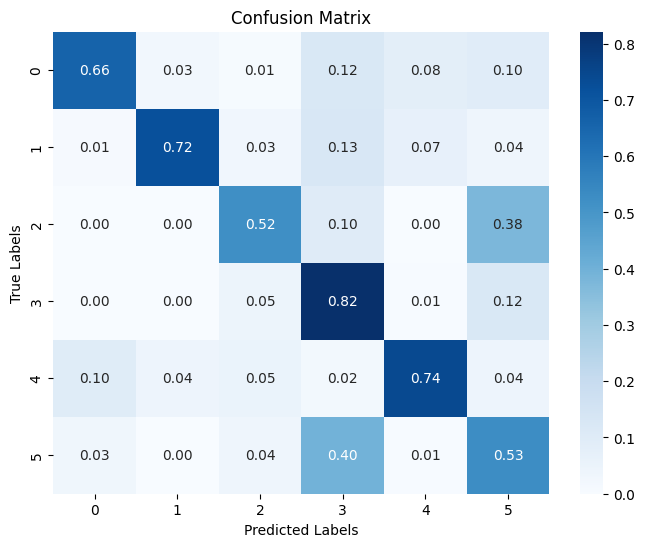

-------- HOS=None --------
Acc. Média Treino: 0.6692 | Acc. Média Teste: 0.6677


In [20]:
mean_acc, test_acc = execute_model(name='mulher2', HOS=True)
print('-------- HOS=True --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher2', HOS=False)
print('-------- HOS=False --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher2', HOS=None)
print('-------- HOS=None --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

## Mulher3

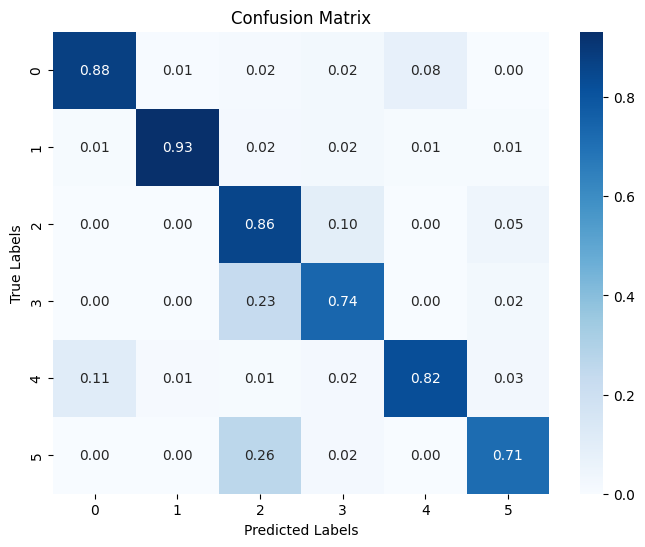

-------- HOS=True --------
Acc. Média Treino: 0.8178 | Acc. Média Teste: 0.8261


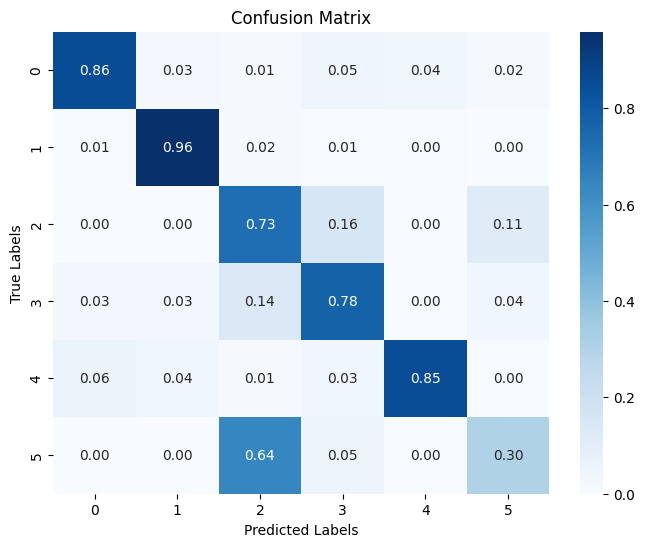

-------- HOS=False --------
Acc. Média Treino: 0.7221 | Acc. Média Teste: 0.7523


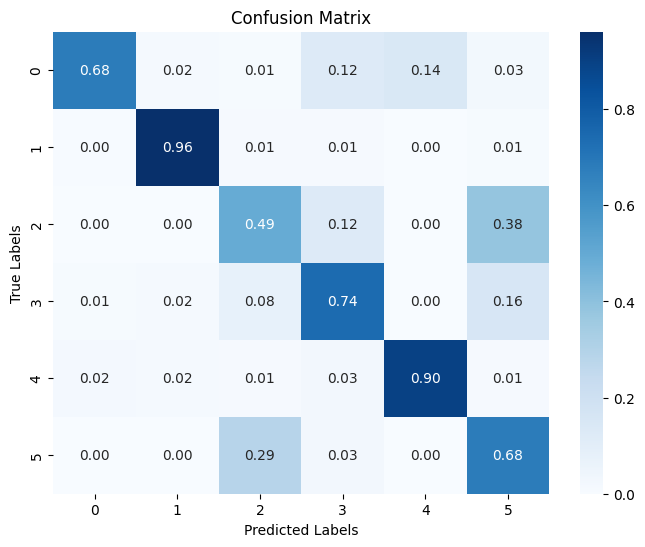

-------- HOS=None --------
Acc. Média Treino: 0.721 | Acc. Média Teste: 0.7488


In [21]:
mean_acc, test_acc = execute_model(name='mulher3', HOS=True)
print('-------- HOS=True --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher3', HOS=False)
print('-------- HOS=False --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')

mean_acc, test_acc = execute_model(name='mulher3', HOS=None)
print('-------- HOS=None --------')
print(f'Acc. Média Treino: {mean_acc} | Acc. Média Teste: {round(test_acc, 4)}')